<a href="https://colab.research.google.com/github/AryanMethil/Speaker-Recognition/blob/main/Speaker_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
import random
import scipy

!pip install tensorflow==2.2.0
!pip install pydub

from pydub import AudioSegment

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

print(tf.__version__)

2.2.0


In [7]:
DATASET_FOLDER = '/content/drive/MyDrive/Speaker Recognition/Dataset/Speaker Recognition Dataset 2/'
DATASET_FOLDER_2 = '/content/drive/MyDrive/Speaker Recognition/Dataset/New Speaker Recognition Dataset/'
FINAL_DATASET_FOLDER = '/content/drive/MyDrive/Speaker Recognition/Dataset/Final Speaker Recognition Dataset/'

In [8]:
import os

inputpath = DATASET_FOLDER
outputpath = FINAL_DATASET_FOLDER

for dirpath, dirnames, filenames in os.walk(inputpath):
    structure = os.path.join(outputpath, dirpath[len(inputpath):])
    if not os.path.isdir(structure):
        os.mkdir(structure)
    else:
        print("Folder does already exits!")

In [19]:
def concatenate_audio_files(DATASET_FOLDER, no_of_files_to_concat=10):
  for folder, subfolder, files in os.walk(DATASET_FOLDER):
    if folder!=DATASET_FOLDER:
      for i in range(0, len(files), no_of_files_to_concat):
        combined_sound = 0
        for j in range(i, i+no_of_files_to_concat):
          combined_sound += AudioSegment.from_wav(os.path.join(folder,f'{j}.wav'))
        combined_sound.export(FINAL_DATASET_FOLDER+folder[folder.rindex('/')+1:]+'/'+f'combined_{i}.wav')  

In [20]:
concatenate_audio_files(DATASET_FOLDER, 10)

In [21]:
DATASET_FOLDER = FINAL_DATASET_FOLDER

In [22]:
def get_training_files(DATASET_FOLDER):
  all_files = []
  for folder, subfolder, files in os.walk(DATASET_FOLDER):
    if(folder != DATASET_FOLDER):
      all_files += [folder+'/'+f for f in files]

  random.shuffle(all_files)
  return all_files, len(all_files)

In [23]:
all_files, no_of_training_files = get_training_files(DATASET_FOLDER=DATASET_FOLDER)
print(all_files, '\n', no_of_training_files)

['/content/drive/MyDrive/Speaker Recognition/Dataset/Final Speaker Recognition Dataset/Magaret_Tarcher/combined_10.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/Final Speaker Recognition Dataset/Julia_Gillard/combined_10.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/Final Speaker Recognition Dataset/Nelson_Mandela/combined_10.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/Final Speaker Recognition Dataset/Magaret_Tarcher/combined_0.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/Final Speaker Recognition Dataset/Julia_Gillard/combined_20.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/Final Speaker Recognition Dataset/Jens_Stoltenberg/combined_20.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/Final Speaker Recognition Dataset/Benjamin_Netanyau/combined_20.wav', '/content/drive/MyDrive/Speaker Recognition/Dataset/Final Speaker Recognition Dataset/Nelson_Mandela/combined_0.wav', '/content/drive/MyDrive/Speaker Recognition/

In [24]:
# Inputs an audio file path and returns the transpose of the mfcc matrix

def get_mfcc_coeffs(audio_file_path, types_of_mfcc_to_extract):
  signal, sr = librosa.load(audio_file_path)
  
  mfcc_matrix =[]

  mfcc = librosa.feature.mfcc(signal,n_mfcc=13,sr=sr)
  if 'MFCC' in types_of_mfcc_to_extract:
    mfcc_matrix.append(mfcc)

  if 'MFCC_1' in types_of_mfcc_to_extract:
    delta_mfcc=librosa.feature.delta(mfcc)
    mfcc_matrix.append(delta_mfcc)

  if 'MFCC_2' in types_of_mfcc_to_extract:
    delta_2_mfcc=librosa.feature.delta(mfcc,order=2)
    mfcc_matrix.append(delta_2_mfcc)

  mfcc_matrix = tuple(mfcc_matrix)

  comprehensive_mfcc = np.concatenate(mfcc_matrix)
  return np.transpose(comprehensive_mfcc)

In [25]:
# Inputs the list of all audio file paths and outputs a feature matrix of shape (#pairs_possible, 2, #frames, #mfcc_coeffs + #delta_mfcc_coeffs + #delta_2_mfcc_coeffs) and a targets vector containining #pairs_possible elements

def create_feature_matrix(all_files, types_of_mfcc_to_extract):
  x=[]
  y=[]

  speaker_name=[]

  for pair in itertools.combinations(all_files,2):
    a,b = pair
    mfcc_a = get_mfcc_coeffs(a, types_of_mfcc_to_extract)
    mfcc_b = get_mfcc_coeffs(b, types_of_mfcc_to_extract)
    x.append([mfcc_a,mfcc_b])
    if(a[83:a.rfind(r"/")]==b[83:b.rfind(r"/")]):
      y.append(1)
      speaker_name.append(((a[83:a.rfind(r"/")],b[83:b.rfind(r"/")]),1))
    else:
      y.append(0)
      speaker_name.append(((a[83:a.rfind(r"/")],b[83:b.rfind(r"/")]),0))
    
  x = np.array(x)
  y = np.array(y)
  return x,y,speaker_name

In [26]:
TYPES_OF_MFCCS = ['MFCC_2']
x,y,speaker_name = create_feature_matrix(all_files, types_of_mfcc_to_extract= TYPES_OF_MFCCS)
print(x.shape)
print(y.shape)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

(105, 2, 431, 13)
(105,)


In [27]:
speaker_name[:20]

[(('t/Magaret_Tarcher', 't/Julia_Gillard'), 0),
 (('t/Magaret_Tarcher', 't/Nelson_Mandela'), 0),
 (('t/Magaret_Tarcher', 't/Magaret_Tarcher'), 1),
 (('t/Magaret_Tarcher', 't/Julia_Gillard'), 0),
 (('t/Magaret_Tarcher', 't/Jens_Stoltenberg'), 0),
 (('t/Magaret_Tarcher', 't/Benjamin_Netanyau'), 0),
 (('t/Magaret_Tarcher', 't/Nelson_Mandela'), 0),
 (('t/Magaret_Tarcher', 't/Nelson_Mandela'), 0),
 (('t/Magaret_Tarcher', 't/Benjamin_Netanyau'), 0),
 (('t/Magaret_Tarcher', 't/Julia_Gillard'), 0),
 (('t/Magaret_Tarcher', 't/Jens_Stoltenberg'), 0),
 (('t/Magaret_Tarcher', 't/Jens_Stoltenberg'), 0),
 (('t/Magaret_Tarcher', 't/Magaret_Tarcher'), 1),
 (('t/Magaret_Tarcher', 't/Benjamin_Netanyau'), 0),
 (('t/Julia_Gillard', 't/Nelson_Mandela'), 0),
 (('t/Julia_Gillard', 't/Magaret_Tarcher'), 0),
 (('t/Julia_Gillard', 't/Julia_Gillard'), 1),
 (('t/Julia_Gillard', 't/Jens_Stoltenberg'), 0),
 (('t/Julia_Gillard', 't/Benjamin_Netanyau'), 0),
 (('t/Julia_Gillard', 't/Nelson_Mandela'), 0)]

In [28]:
def downsample_dissimilar_class(x,y,speaker_name):
  indices_dissimilar_class = [i for i,num in enumerate(y) if num==0]
  indices_similar_class = [i for i,num in enumerate(y) if num==1]
  downsampled_indices_dissimilar_class = random.sample(indices_dissimilar_class, np.unique(y,return_counts=True)[1][1])
  y = [y[i] for i in downsampled_indices_dissimilar_class+indices_similar_class]
  x = [x[i] for i in downsampled_indices_dissimilar_class+indices_similar_class]
  speaker_name = [speaker_name[i] for i in downsampled_indices_dissimilar_class+indices_similar_class]
  return x,y,speaker_name

In [29]:
x,y,speaker_name = downsample_dissimilar_class(x,y,speaker_name)
# Print the number class-wise unique values
print(np.unique(y,return_counts=True))

(array([0, 1]), array([15, 15]))


In [30]:
from sklearn.utils import shuffle
x,y = shuffle(x,y,random_state=42)

In [31]:
print(y[:20])

[1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]


In [32]:
x=np.array(x)
y=np.array(y)

In [33]:
def show_random_pair(x,y,show=False):
  if show:
    %matplotlib inline
    indices_dissimilar_class = [i for i,x in enumerate(y) if x==0]
    indices_similar_class = [i for i,x in enumerate(y) if x==1]

    random_dissim_pair=random.choice(indices_dissimilar_class)
    random_sim_pair=random.choice(indices_similar_class)

    for i,pair_no in enumerate((random_dissim_pair,random_sim_pair)):
      plt.figure(figsize=(20,10))
      plt.suptitle("Dissimilar" if i==0 else "Similar")
      plt.subplot(2,3,1)
      librosa.display.specshow(np.transpose(x[pair_no][0][:][:13]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      plt.subplot(2,3,2)
      librosa.display.specshow(np.transpose(x[pair_no][0][:][13:26]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      plt.subplot(2,3,3)
      librosa.display.specshow(np.transpose(x[pair_no][0][:][26:]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      plt.subplot(2,3,4)
      librosa.display.specshow(np.transpose(x[pair_no][1][:][:13]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      plt.subplot(2,3,5)
      librosa.display.specshow(np.transpose(x[pair_no][1][:][13:26]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      plt.subplot(2,3,6)
      librosa.display.specshow(np.transpose(x[pair_no][1][:][26:]),x_axis="time",sr=22050)
      plt.colorbar(format="%+2f")

      print('\n')
    plt.show()

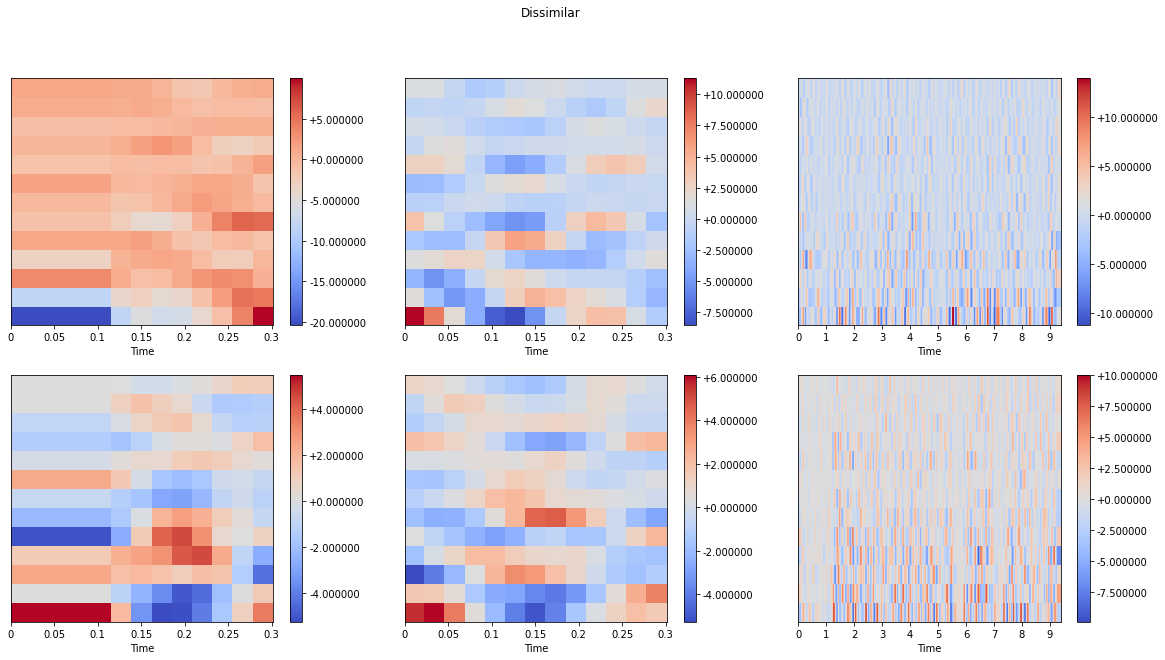

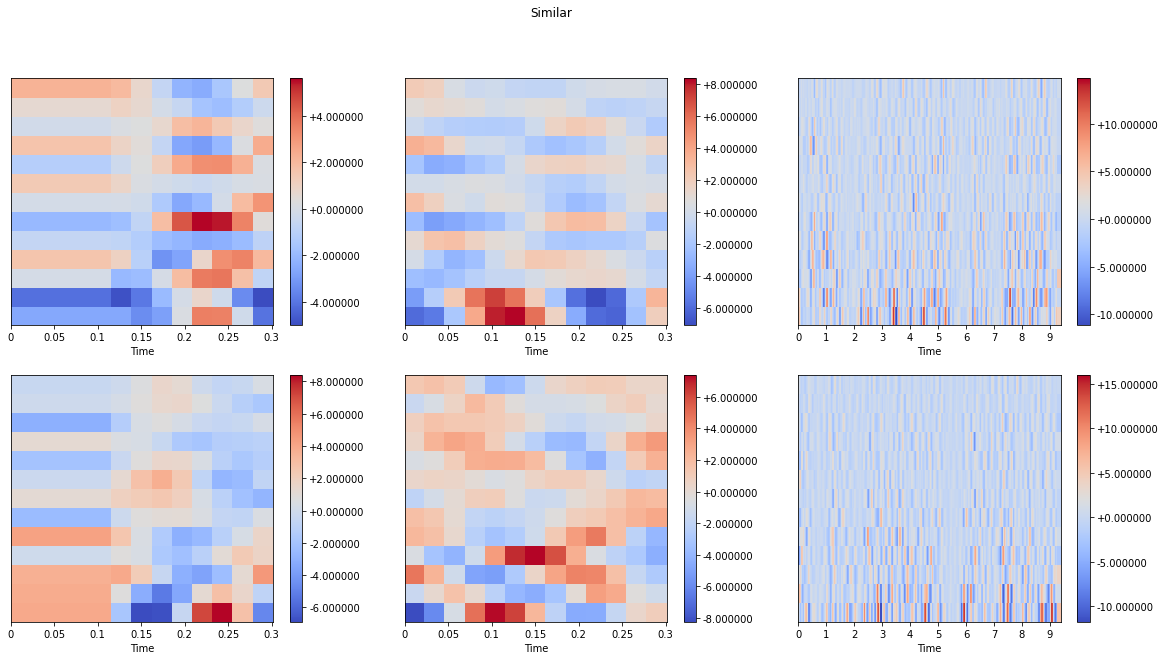

In [34]:
show_random_pair(x,y,show=True)

In [40]:
def initialize_base_network():
    input = Input(shape=(431,13,), name="base_input")
    x = LSTM(128,return_sequences=True)(input)
    x = LSTM(64)(x)
    x = Dense(128,activation='relu')(x)

    return Model(inputs=input, outputs=x)


def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [41]:
base_network = initialize_base_network()

In [42]:
input_a = Input(shape=(431,13,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(431,13,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

In [43]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [ ]:
margins = [0.1,0.2,0.5,1.0,1.5,2.0,2.5,3,3.5,4,4.5,5,6,7,8,9,10]
loss_wrt_margin = []
acc_wrt_margin = []
for margin in margins:
  print(f'Current Margin used for Contrastive loss : {margin}')
  model.compile(loss=contrastive_loss_with_margin(margin=margin), 
                optimizer=Adam(learning_rate=0.01),
                metrics=['accuracy'])
  history = model.fit([x[:,0], x[:,1]], y, epochs=20, batch_size=32, verbose=0)
  loss_wrt_margin.append(history.history['loss'][-1])
  acc_wrt_margin.append(history.history['accuracy'][-1])

Current Margin used for Contrastive loss : 0.1
Current Margin used for Contrastive loss : 0.2
Current Margin used for Contrastive loss : 0.5
Current Margin used for Contrastive loss : 1.0
Current Margin used for Contrastive loss : 1.5
Current Margin used for Contrastive loss : 2.0
Current Margin used for Contrastive loss : 2.5
Current Margin used for Contrastive loss : 3
Current Margin used for Contrastive loss : 3.5
Current Margin used for Contrastive loss : 4
Current Margin used for Contrastive loss : 4.5
Current Margin used for Contrastive loss : 5
Current Margin used for Contrastive loss : 6
Current Margin used for Contrastive loss : 7
Current Margin used for Contrastive loss : 8
Current Margin used for Contrastive loss : 9
Current Margin used for Contrastive loss : 10


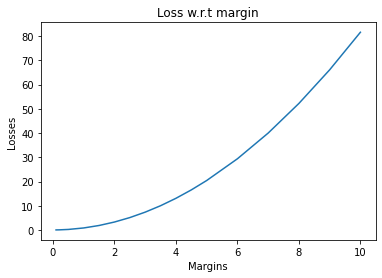

In [ ]:
plt.plot(margins,loss_wrt_margin)
plt.title('Loss w.r.t margin')
plt.xlabel('Margins')
plt.ylabel('Losses')
plt.show()

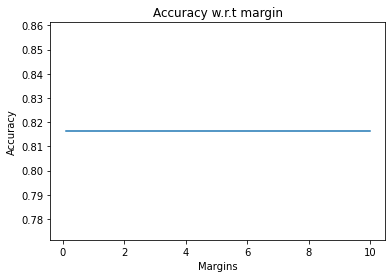

In [ ]:
plt.plot(margins,acc_wrt_margin)
plt.title('Accuracy w.r.t margin')
plt.xlabel('Margins')
plt.ylabel('Accuracy')
plt.show()

In [44]:
model.compile(loss=contrastive_loss_with_margin(margin=1), 
                optimizer=Adam(learning_rate=0.01),
                metrics=['accuracy'])
history = model.fit([x[:,0], x[:,1]], y, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5123 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4650 - accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.2325 - accuracy: 0.4333
Epoch 4/100
1/1 [==============================] - 0s 10ms/step - loss: 0.1753 - accuracy: 0.1333
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1278 - accuracy: 0.0667
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0958 - accuracy: 0.1333
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1147 - accuracy: 0.0667
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0842 - accuracy: 0.1333
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0483 - accuracy: 0.0333
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0335 - accuracy: 0.0000e+00
Epoch 11/100
1/1 [======